# Fundus Analysis Cataract

In [ ]:
!nvidia-smi

Sat Mar  6 19:41:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Import Data from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!ls

categorized_disorders  kaggle.json
categorized_images     models
disorder_model.h5      vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
images


**Download Data in Colab**

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:14<00:00, 149MB/s]
100% 1.62G/1.62G [00:14<00:00, 120MB/s]


In [ ]:
!ls

full_df.csv
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
kaggle.json
Kuszma.JPG
ocular-disease-recognition-odir5k.zip
ODIR-5K
preprocessed_images
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


**Un-zip the Data**

In [ ]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

## Classfication

Import Statements

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Kaggle/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0

df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
print(left_glaucoma[:10])

right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
print(right_glaucoma[:10])

['95_left.jpg' '153_left.jpg' '167_left.jpg' '178_left.jpg' '247_left.jpg'
 '365_left.jpg' '583_left.jpg' '625_left.jpg' '746_left.jpg'
 '931_left.jpg']
['43_right.jpg' '167_right.jpg' '238_right.jpg' '247_right.jpg'
 '365_right.jpg' '583_right.jpg' '746_right.jpg' '931_right.jpg'
 '1209_right.jpg' '1210_right.jpg']


In [ ]:
print("Left Eye Images having Glaucoma: {}".format(len(left_glaucoma)))
print("Right Eye Images having Glaucoma: {}".format(len(right_glaucoma)))

Left Eye Images having Glaucoma: 332
Right Eye Images having Glaucoma: 284


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values

right_normal[:10]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg'], dtype=object)

Left and Right Images Together

In [ ]:
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print("Glaucoma: {}".format(len(glaucoma)))
print("Normal: {}".format(len(normal)))

Glaucoma: 616
Normal: 600


In [ ]:
dataset_dir = "/content/gdrive/MyDrive/Kaggle/preprocessed_images/"

image_size = 224

labels = []
dataset = []

def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
        
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(glaucoma,1)

100%|██████████| 616/616 [00:04<00:00, 153.91it/s]


In [ ]:
len(dataset)

613

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [00:03<00:00, 153.53it/s]


In [ ]:
len(dataset)

1213

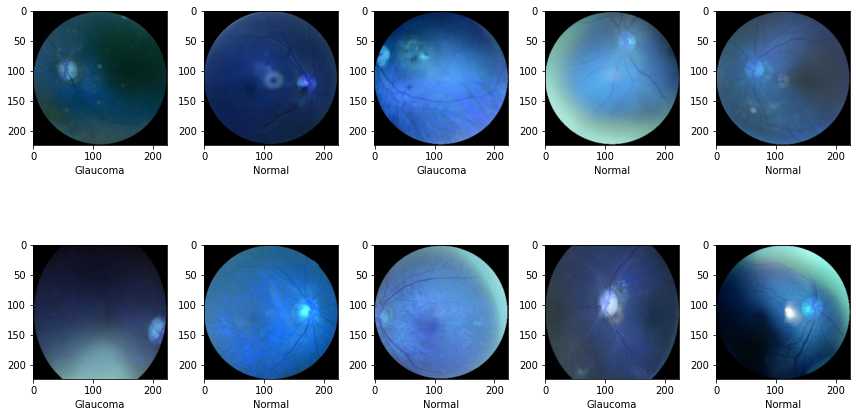

In [ ]:
plt.figure(figsize=(12,7))

for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category == 0:
        label = "Normal"
    else:
        label = "Glaucoma"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

**Keras Pretrained Models**

In [ ]:
!kaggle datasets download -d gaborfodor/keras-pretrained-models

 99% 934M/943M [00:08<00:00, 123MB/s]
100% 943M/943M [00:08<00:00, 114MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  keras-pretrained-models.zip
  inflating: Kuszma.JPG              
  inflating: imagenet_class_index.json  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  
replace vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: xception_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: xception_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
!ls

categorized_disorders
categorized_images
disorder_model.h5
full_df.csv
imagenet_class_index.json
images
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
kaggle.json
Kuszma.JPG
models
ODIR-5K
preprocessed_images
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_weight_path = '/content/gdrive/MyDrive/Kaggle/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

vgg = VGG16(
    weights = vgg16_weight_path,
    include_top = False, 
    input_shape = (224,224,3)
)

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

**Model**

In [ ]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten ,Dense

model = Sequential()

model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

Model's Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size = 32,
                    epochs = 60,
                    validation_data = (x_test, y_test)
                    )

Epoch 1/60
31/31 [==============================] - 6s 155ms/step - loss: 0.8401 - accuracy: 0.4978 - val_loss: 0.5450 - val_accuracy: 0.7531
Epoch 2/60
31/31 [==============================] - 5s 147ms/step - loss: 0.5468 - accuracy: 0.7141 - val_loss: 0.5016 - val_accuracy: 0.7531
Epoch 3/60
31/31 [==============================] - 5s 148ms/step - loss: 0.4759 - accuracy: 0.7728 - val_loss: 0.4649 - val_accuracy: 0.7860
Epoch 4/60
31/31 [==============================] - 5s 149ms/step - loss: 0.4435 - accuracy: 0.7781 - val_loss: 0.5261 - val_accuracy: 0.7284
Epoch 5/60
31/31 [==============================] - 5s 149ms/step - loss: 0.4271 - accuracy: 0.7926 - val_loss: 0.4899 - val_accuracy: 0.8025
Epoch 6/60
31/31 [==============================] - 5s 150ms/step - loss: 0.3368 - accuracy: 0.8491 - val_loss: 0.4223 - val_accuracy: 0.8189
Epoch 7/60
31/31 [==============================] - 5s 151ms/step - loss: 0.3240 - accuracy: 0.8688 - val_loss: 0.4348 - val_accuracy: 0.8230
Epoch 

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [ ]:
model.save('fundus_glaucoma.h5')

In [ ]:
!ls

full_df.csv
fundus_model.h5
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
kaggle.json
Kuszma.JPG
ODIR-5K
preprocessed_images
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
accuracy_score(y_test,y_pred)

0.8641975308641975

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.78      0.85       116
           1       0.83      0.94      0.88       127

    accuracy                           0.86       243
   macro avg       0.87      0.86      0.86       243
weighted avg       0.87      0.86      0.86       243



In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


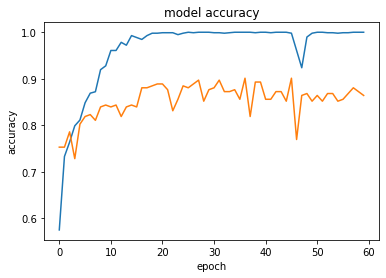

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

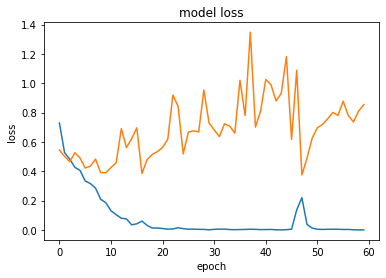

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from IPython.display import FileLink, FileLinks
FileLinks('.')

./
  vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
  disorder_model.h5
  kaggle.json
  full_df.csv
  Kuszma.JPG
  imagenet_class_index.json
  inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
  inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
  inception_v3_weights_tf_dim_ordering_tf_kernels.h5
  inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  resnet50_weights_tf_dim_ordering_tf_kernels.h5
  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
  xception_weights_tf_dim_ordering_tf_kernels.h5
  xception_weights_tf_dim_ordering_tf_kernels_notop.h5
  fundus_glaucoma.h5
./ODIR-5K/ODIR-5K/
  data.xlsx
./ODIR-5K/ODIR-5K/Testing Images/
  1000_left.jpg
  1000_right.jpg
  1001_left.jpg
  1001_right.jpg
  1002_left.jpg
  1002_right.jpg
  1003_left.jpg
  1003_right.jpg
  1004_left.jpg
  1004_right.jpg
  1007_left.jpg
  1007_right.jpg
  1009_left.jpg
  1009_right.jpg
  1026_left.jpg
  1026_right.jpg
  1027_left.jpg
  1027_right.jpg
  1029_left.jpg
  1029_right.jpg
  1030_left.jpg
  1030_right.jpg
  1037_left.jpg
  1037_right.jpg
  1042_left.jpg
  1042_right.jpg
  1044_left.jpg
  1044_right.jpg
  1047_left.jpg
  1047_right.jpg
  1049_left.jpg
  1049_right.jpg
  1051_left.jpg
  1051_right.jpg
  1055_left.jpg
  1055_right.jpg
  1057_left.jpg
  1057_right.jpg
  1063_left.jpg
  1063_right.jpg
  1067_left.jpg
  1067_right.jpg
  1069_left.jpg
  1069_right.jpg
  1070_left.jpg
  1070_right.jpg
  1073_left.jpg
  1073_right.jpg
  1076_left.jpg
  1076_right.jpg
  1078_left.jpg
  1078_right.jpg
  1088_left.jpg
  1088_right.jpg
  1100_left.jpg
  1100_right.jpg
  1105_left.jpg
  1105_right.jpg
  1107_left.jpg
  1107_right.jpg
  1108_left.jpg
  1108_right.jpg
  1110_left.jpg
  1110_right.jpg
  1112_left.jpg
  1112_right.jpg
  1128_left.jpg
  1128_right.jpg
  1135_left.jpg
  1135_right.jpg
  1178_left.jpg
  1178_right.jpg
  1179_left.jpg
  1179_right.jpg
  1180_left.jpg
  1180_right.jpg
  1183_left.jpg
  1183_right.jpg
  1184_left.jpg
  1184_right.jpg
  1192_left.jpg
  1192_right.jpg
  1193_left.jpg
  1193_right.jpg
  1199_left.jpg
  1199_right.jpg
  1201_left.jpg
  1201_right.jpg
  1224_left.jpg
  1224_right.jpg
  1244_left.jpg
  1244_right.jpg
  1249_left.jpg
  1249_right.jpg
  1252_left.jpg
  1252_right.jpg
  1257_left.jpg
  1257_right.jpg
  1275_left.jpg
  1275_right.jpg
  1283_left.jpg
  1283_right.jpg
  1292_left.jpg
  1292_right.jpg
  1298_left.jpg
  1298_right.jpg
  1300_left.jpg
  1300_right.jpg
  1305_left.jpg
  1305_right.jpg
  1312_left.jpg
  1312_right.jpg
  1315_left.jpg
  1315_right.jpg
  1317_left.jpg
  1317_right.jpg
  1321_left.jpg
  1321_right.jpg
  1322_left.jpg
  1322_right.jpg
  1323_left.jpg
  1323_right.jpg
  1324_left.jpg
  1324_right.jpg
  1326_left.jpg
  1326_right.jpg
  1329_left.jpg
  1329_right.jpg
  1331_left.jpg
  1331_right.jpg
  1333_left.jpg
  1333_right.jpg
  1335_left.jpg
  1335_right.jpg
  1336_left.jpg
  1336_right.jpg
  1338_left.jpg
  1338_right.jpg
  1339_left.jpg
  1339_right.jpg
  1340_left.jpg
  1340_right.jpg
  1341_left.jpg
  1341_right.jpg
  1343_left.jpg
  1343_right.jpg
  1346_left.jpg
  1346_right.jpg
  1347_left.jpg
  1347_right.jpg
  1348_left.jpg
  1348_right.jpg
  1354_left.jpg
  1354_right.jpg
  1355_left.jpg
  1355_right.jpg
  1357_left.jpg
  1357_right.jpg
  1359_left.jpg
  1359_right.jpg
  1361_left.jpg
  1361_right.jpg
  1363_left.jpg
  1363_right.jpg
  1367_left.jpg
  1367_right.jpg
  1370_left.jpg
  1370_right.jpg
  1375_left.jpg
  1375_right.jpg
  1376_left.jpg
  1376_right.jpg
  1379_left.jpg
  1379_right.jpg
  1380_left.jpg
  1380_right.jpg
  1381_left.jpg
  1381_right.jpg
  1382_left.jpg
  1382_right.jpg
  1385_left.jpg
  1385_right.jpg
  1390_left.jpg
  1390_right.jpg
  1395_left.jpg
  1395_right.jpg
  1398_left.jpg
  1398_right.jpg
  1399_left.jpg
  1399_right.jpg
  1400_left.jpg
  1400_right.jpg
  1403_left.jpg
  1403_right.jpg
  1407_left.jpg
  1407_right.jpg
  1430_left.jpg
  1430_right.jpg
  1432_left.jpg
  1432_right.jpg
  1437_left.jpg
  1437_r